In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data
from scipy.fftpack import dct, idct, fft2, ifft2
from skimage.metrics import mean_squared_error


1. Convert the Image to Grayscale :use an in-built function rgb2gray from the skimage.color module to convert a color image to grayscale.

In [81]:
image_color = data.astronaut()
image_gray = color.rgb2gray(image_color)
image_gray = image_gray.copy()

2. Division of Image into Blocks : We divide the image into non-overlapping blocks of size 8×8

In [82]:
def blockify(img, block_size):
    h, w = img.shape  
    blocks = (img.reshape(h // block_size, block_size, -1, block_size).swapaxes(1, 2).reshape(-1, block_size, block_size))
    return blocks

h, w = image_gray.shape
print(f"Height of the original image: {h}")
print(f"Width of the original image: {w}")
block_size = 8
blocks = blockify(image_gray, block_size)
print(f"Image was divided into {blocks.shape[0]} blocks, each of size {blocks.shape[1]}x{blocks.shape[2]}.")
#print("First block:\n", blocks[0])


Height of the original image: 512
Width of the original image: 512
Image was divided into 4096 blocks, each of size 8x8.


3. Transform of Blocks : Discrete Fourier Transform (DFT) and Cosin Fourier Transform (CFT)

In [83]:
dft_blocks = np.fft.fft2(blocks, axes=(1, 2)) 
dct_blocks = dct(dct(blocks, axis=1, norm='ortho'), axis=2, norm='ortho')
                       
dft_magnitude = np.log(np.abs(dft_blocks[0]) + 1e-5)   
dct_magnitude = np.abs(dct_blocks[0])
#print(f"DFT applied. The transformed blocks have the shape {dft_blocks.shape}.")
#print("Magnitude of the first block after DFT:\n", np.abs(dft_blocks[0])

4. Truncation or Quantization : We retain only the largest num_coefficients in each block.

In [84]:
num_coefficients=16
def truncate_blocks(blocks, num_coefficients):
    truncated_blocks = np.zeros_like(blocks)
    for i, block in enumerate(blocks):
        flat_block = block.flatten()
        sorted_idx = np.argsort(-np.abs(flat_block))   
        largest_indices = sorted_idx[:num_coefficients]   
        truncated_block = np.zeros_like(flat_block)
        truncated_block[largest_indices] = flat_block[largest_indices]
        truncated_blocks[i] = truncated_block.reshape(block.shape)
    return truncated_blocks

truncated_dft_blocks = truncate_blocks(dft_blocks, num_coefficients)
truncated_dct_blocks = truncate_blocks(dct_blocks, num_coefficients)
truncated_dft_magnitude = np.log(np.abs(truncated_dft_blocks) + 1e-5)
truncated_dct_magnitude = np.abs(truncated_dct_blocks)

5. Apply inverse DFT and DCT

In [90]:
idft_blocks = np.fft.ifft2(truncated_dft_blocks, axes=(1, 2)).real
idct_blocks = idct(idct(truncated_dct_blocks, axis=1, norm='ortho'), axis=2, norm='ortho')


6. Reassemble the images

In [91]:
def unblockify(blocks, image_shape, block_size):
    h, w = image_shape
    img = (blocks.reshape(h // block_size, -1, block_size, block_size)
               .swapaxes(1, 2)
               .reshape(h, w))
    return img

dft_reconstructed = unblockify(idft_blocks, image_gray.shape, block_size)
dct_reconstructed = unblockify(idct_blocks, image_gray.shape, block_size)

Compute the error for both methods

In [92]:
dft_error = np.mean((image_gray - dft_reconstructed) ** 2)
dct_error = np.mean((image_gray - dct_reconstructed) ** 2)
print(f"DFT Reconstruction Error (MSE): {dft_error}")
print(f"DCT Reconstruction Error (MSE): {dct_error}")

DFT Reconstruction Error (MSE): 0.0007933182192720991
DCT Reconstruction Error (MSE): 0.0002653063716327014


In [93]:
def visualize_stage(image_list, titles, cols=2):
    rows = len(image_list) // cols + (len(image_list) % cols > 0)
    plt.figure(figsize=(10, 10))
    for i, (image, title) in enumerate(zip(image_list, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

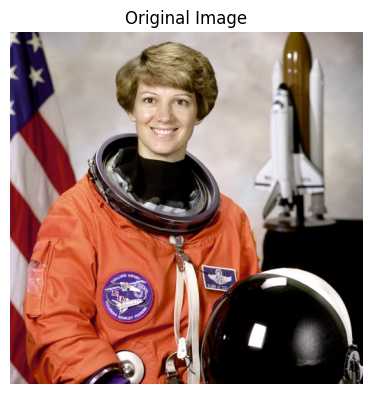

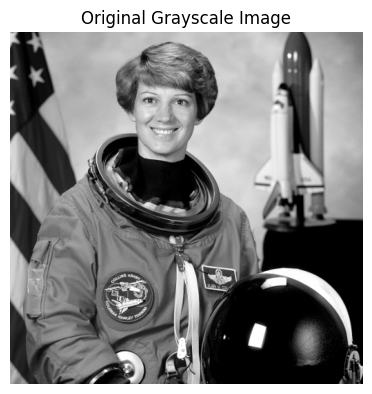

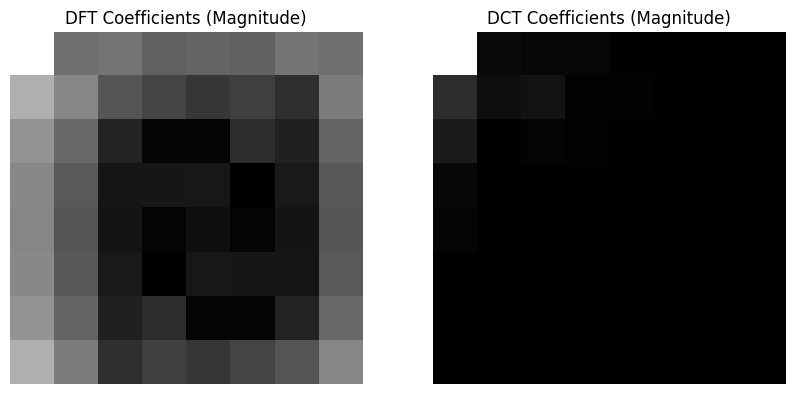

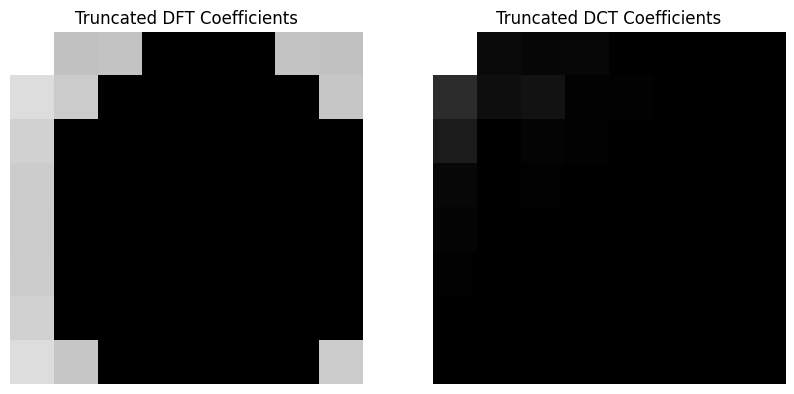

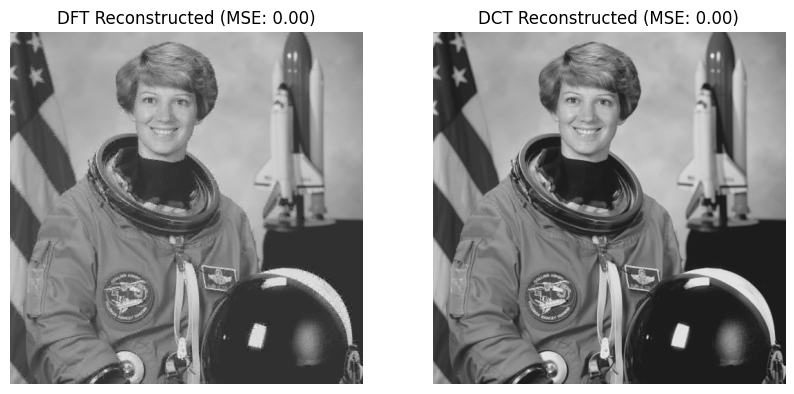

In [94]:
visualize_stage([image_color], ['Original Image'])
visualize_stage([image_gray], ['Original Grayscale Image'])
visualize_stage([dft_magnitude, dct_magnitude], ['DFT Coefficients (Magnitude)', 'DCT Coefficients (Magnitude)'])
visualize_stage([truncated_dft_magnitude[0], truncated_dct_magnitude[0]], ['Truncated DFT Coefficients', 'Truncated DCT Coefficients'])
visualize_stage([dft_reconstructed, dct_reconstructed],[f"DFT Reconstructed (MSE: {dft_error:.2f})", f"DCT Reconstructed (MSE: {dct_error:.2f})"])
